In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Titanic-Dataset.csv')
print(df.head())
print(df.info())
print(df.describe())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

In [4]:
# Drop columns that won't be used for prediction
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

# Fill missing values in 'Age' with the median value
df['Age'] = df['Age'].fillna(df['Age'].median())

# Fill missing values in 'Embarked' with the mode value
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# Convert categorical variables to numeric
df = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=True)

print(df.isnull().sum())  # Verify no missing values remain
print(df.head())


Survived      0
Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_male      0
Embarked_Q    0
Embarked_S    0
dtype: int64
   Survived  Pclass   Age  SibSp  Parch     Fare  Sex_male  Embarked_Q  \
0         0       3  22.0      1      0   7.2500      True       False   
1         1       1  38.0      1      0  71.2833     False       False   
2         1       3  26.0      0      0   7.9250     False       False   
3         1       1  35.0      1      0  53.1000     False       False   
4         0       3  35.0      0      0   8.0500      True       False   

   Embarked_S  
0        True  
1       False  
2        True  
3        True  
4        True  


In [9]:
# Create a new feature 'FamilySize'
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
# Create interaction feature 'Age*Class'
df['Age*Class'] = df['Age'] * df['Pclass']


In [10]:
from sklearn.model_selection import train_test_split

# Define features and target variable
X = df.drop('Survived', axis=1)
y = df['Survived']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Best estimator
best_rf = grid_search.best_estimator_


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters found:  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Initialize models
logreg = LogisticRegression(max_iter=200)
dtree = DecisionTreeClassifier()

# Train models
logreg.fit(X_train, y_train)
dtree.fit(X_train, y_train)
best_rf.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomForestClassifier(max_depth=10, min_samples_leaf=2, n_estimators=300)

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Evaluate Logistic Regression
y_pred_logreg = logreg.predict(X_test)
print('Logistic Regression Accuracy:', accuracy_score(y_test, y_pred_logreg))
print(confusion_matrix(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

# Evaluate Decision Tree
y_pred_dtree = dtree.predict(X_test)
print('Decision Tree Accuracy:', accuracy_score(y_test, y_pred_dtree))
print(confusion_matrix(y_test, y_pred_dtree))
print(classification_report(y_test, y_pred_dtree))

# Evaluate Best Random Forest
y_pred_rf = best_rf.predict(X_test)
print('Best Random Forest Accuracy:', accuracy_score(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Logistic Regression Accuracy: 0.8044692737430168
[[91 14]
 [21 53]]
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       105
           1       0.79      0.72      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179

Decision Tree Accuracy: 0.770949720670391
[[84 21]
 [20 54]]
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       105
           1       0.72      0.73      0.72        74

    accuracy                           0.77       179
   macro avg       0.76      0.76      0.76       179
weighted avg       0.77      0.77      0.77       179

Best Random Forest Accuracy: 0.8379888268156425
[[96  9]
 [20 54]]
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       105
           1       0.86      0.73      0.

In [14]:
from sklearn.ensemble import VotingClassifier

# Combine models into a voting classifier
voting_clf = VotingClassifier(estimators=[
    ('lr', logreg),
    ('dt', dtree),
    ('rf', best_rf)
], voting='hard')

# Train the voting classifier
voting_clf.fit(X_train, y_train)

# Evaluate the voting classifier
y_pred_voting = voting_clf.predict(X_test)
print('Voting Classifier Accuracy:', accuracy_score(y_test, y_pred_voting))
print(confusion_matrix(y_test, y_pred_voting))
print(classification_report(y_test, y_pred_voting))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Voting Classifier Accuracy: 0.8100558659217877
[[93 12]
 [22 52]]
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       105
           1       0.81      0.70      0.75        74

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179



In [15]:
from sklearn.ensemble import VotingClassifier

# Combine models into a voting classifier
voting_clf = VotingClassifier(estimators=[
    ('lr', logreg),
    ('dt', dtree),
    ('rf', best_rf)
], voting='hard')

# Train the voting classifier
voting_clf.fit(X_train, y_train)

# Evaluate the voting classifier
y_pred_voting = voting_clf.predict(X_test)
voting_accuracy = accuracy_score(y_test, y_pred_voting)
voting_conf_matrix = confusion_matrix(y_test, y_pred_voting)
voting_class_report = classification_report(y_test, y_pred_voting)

# Display results
voting_accuracy, voting_conf_matrix, voting_class_report


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.8212290502793296,
 array([[93, 12],
        [20, 54]]),
 '              precision    recall  f1-score   support\n\n           0       0.82      0.89      0.85       105\n           1       0.82      0.73      0.77        74\n\n    accuracy                           0.82       179\n   macro avg       0.82      0.81      0.81       179\nweighted avg       0.82      0.82      0.82       179\n')

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Accuracy values from the models
logreg_accuracy = 0.8044692737430168
dtree_accuracy = 0.770949720670391
rf_accuracy = 0.8379888268156425
voting_accuracy = 0.8100558659217877

# Confusion matrices from the models
logreg_conf_matrix = np.array([[91, 14], [21, 53]])
dtree_conf_matrix = np.array([[84, 21], [20, 54]])
rf_conf_matrix = np.array([[96, 9], [20, 54]])
voting_conf_matrix = np.array([[93, 12], [22, 52]])

# Classification reports for class '1'
logreg_report = {'precision': 0.79, 'recall': 0.72, 'f1-score': 0.75}
dtree_report = {'precision': 0.72, 'recall': 0.73, 'f1-score': 0.72}
rf_report = {'precision': 0.86, 'recall': 0.73, 'f1-score': 0.79}
voting_report = {'precision': 0.81, 'recall': 0.70, 'f1-score': 0.75}

# Define model names and their respective accuracies
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Voting Classifier']
accuracies = [logreg_accuracy, dtree_accuracy, rf_accuracy, voting_accuracy]





In [23]:

# Precision, Recall, and F1-Score Comparison
metrics = ['precision', 'recall', 'f1-score']
logreg_metrics = [logreg_report[metric] for metric in metrics]
dtree_metrics = [dtree_report[metric] for metric in metrics]
rf_metrics = [rf_report[metric] for metric in metrics]
voting_metrics = [voting_report[metric] for metric in metrics]

# Create DataFrame for plotting
metrics_df = pd.DataFrame({
    'Metric': metrics,
    'Logistic Regression': logreg_metrics,
    'Decision Tree': dtree_metrics,
    'Random Forest': rf_metrics,
    'Voting Classifier': voting_metrics
})

metrics_df.set_index('Metric', inplace=True)

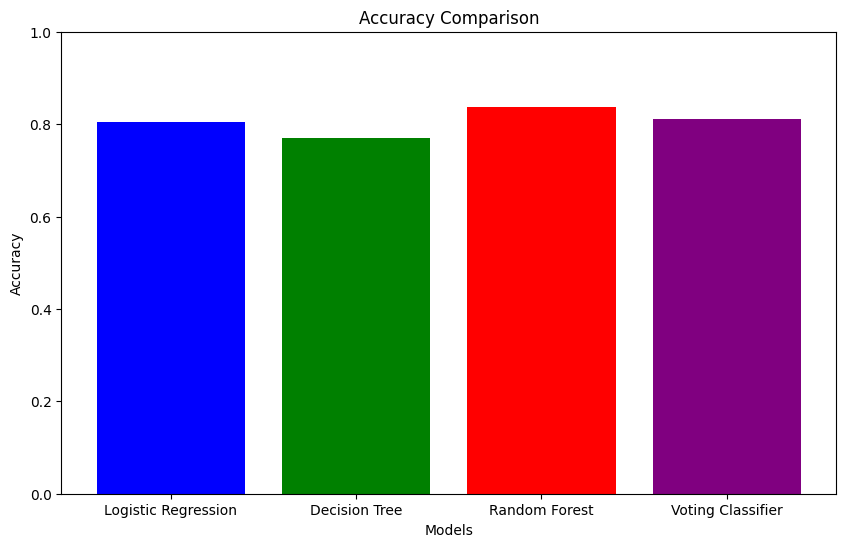

In [22]:
# Plot Accuracy Comparison
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.ylim(0, 1)
plt.show()


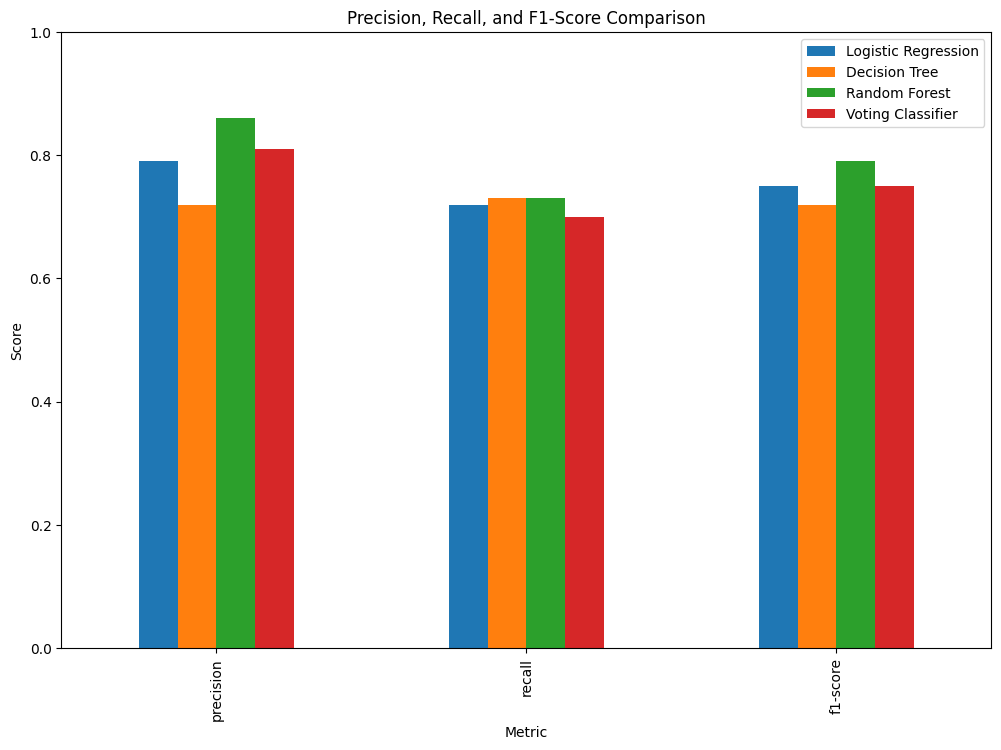

In [21]:
# Plot Precision, Recall, and F1-Score Comparison
metrics_df.plot(kind='bar', figsize=(12, 8))
plt.title('Precision, Recall, and F1-Score Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

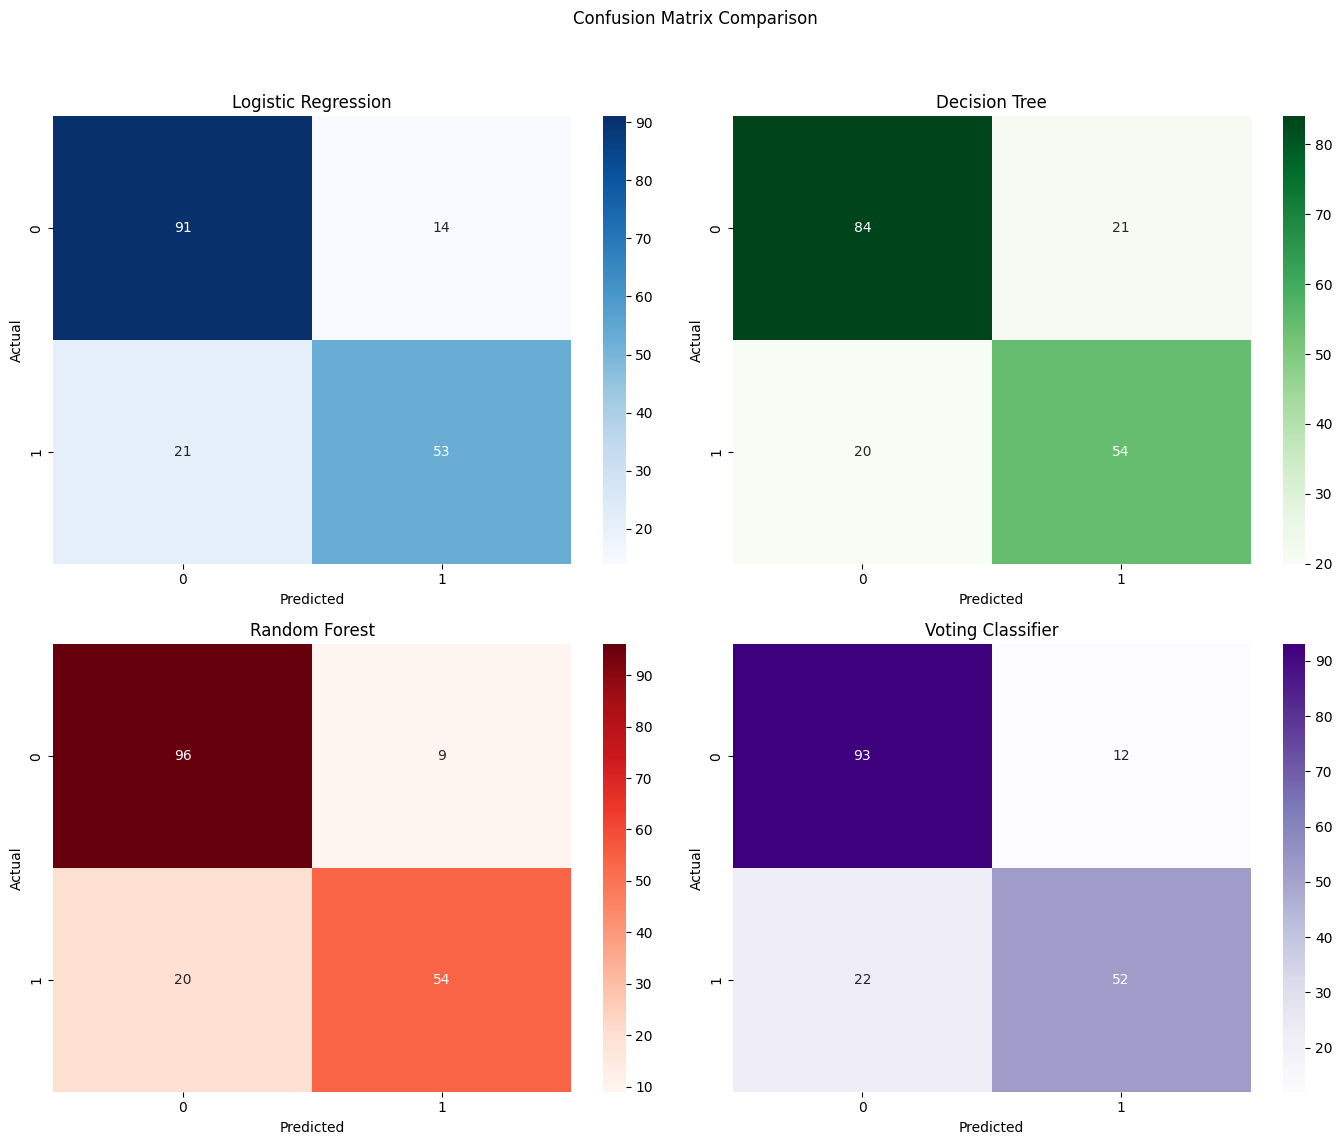

In [24]:
# Plot Confusion Matrices
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Confusion Matrix Comparison')

sns.heatmap(logreg_conf_matrix, annot=True, fmt='d', ax=axes[0, 0], cmap='Blues')
axes[0, 0].set_title('Logistic Regression')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')

sns.heatmap(dtree_conf_matrix, annot=True, fmt='d', ax=axes[0, 1], cmap='Greens')
axes[0, 1].set_title('Decision Tree')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')

sns.heatmap(rf_conf_matrix, annot=True, fmt='d', ax=axes[1, 0], cmap='Reds')
axes[1, 0].set_title('Random Forest')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')

sns.heatmap(voting_conf_matrix, annot=True, fmt='d', ax=axes[1, 1], cmap='Purples')
axes[1, 1].set_title('Voting Classifier')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()